# <center> <font size = 40 color=red> The Lift Curve Unveiled with the Cardiography UCI Dataset</font></center>

The goal of this notebook is to complement a Medium post that explains how to use the Lift Curve to asses classification performance. In it, we will use the UCI Cardiography Dataset for a binary classification task where we want to asses if patient has heart disease or not based on some of his physical attributes.

Link to the data: http://archive.ics.uci.edu/ml/datasets/Cardiotocography

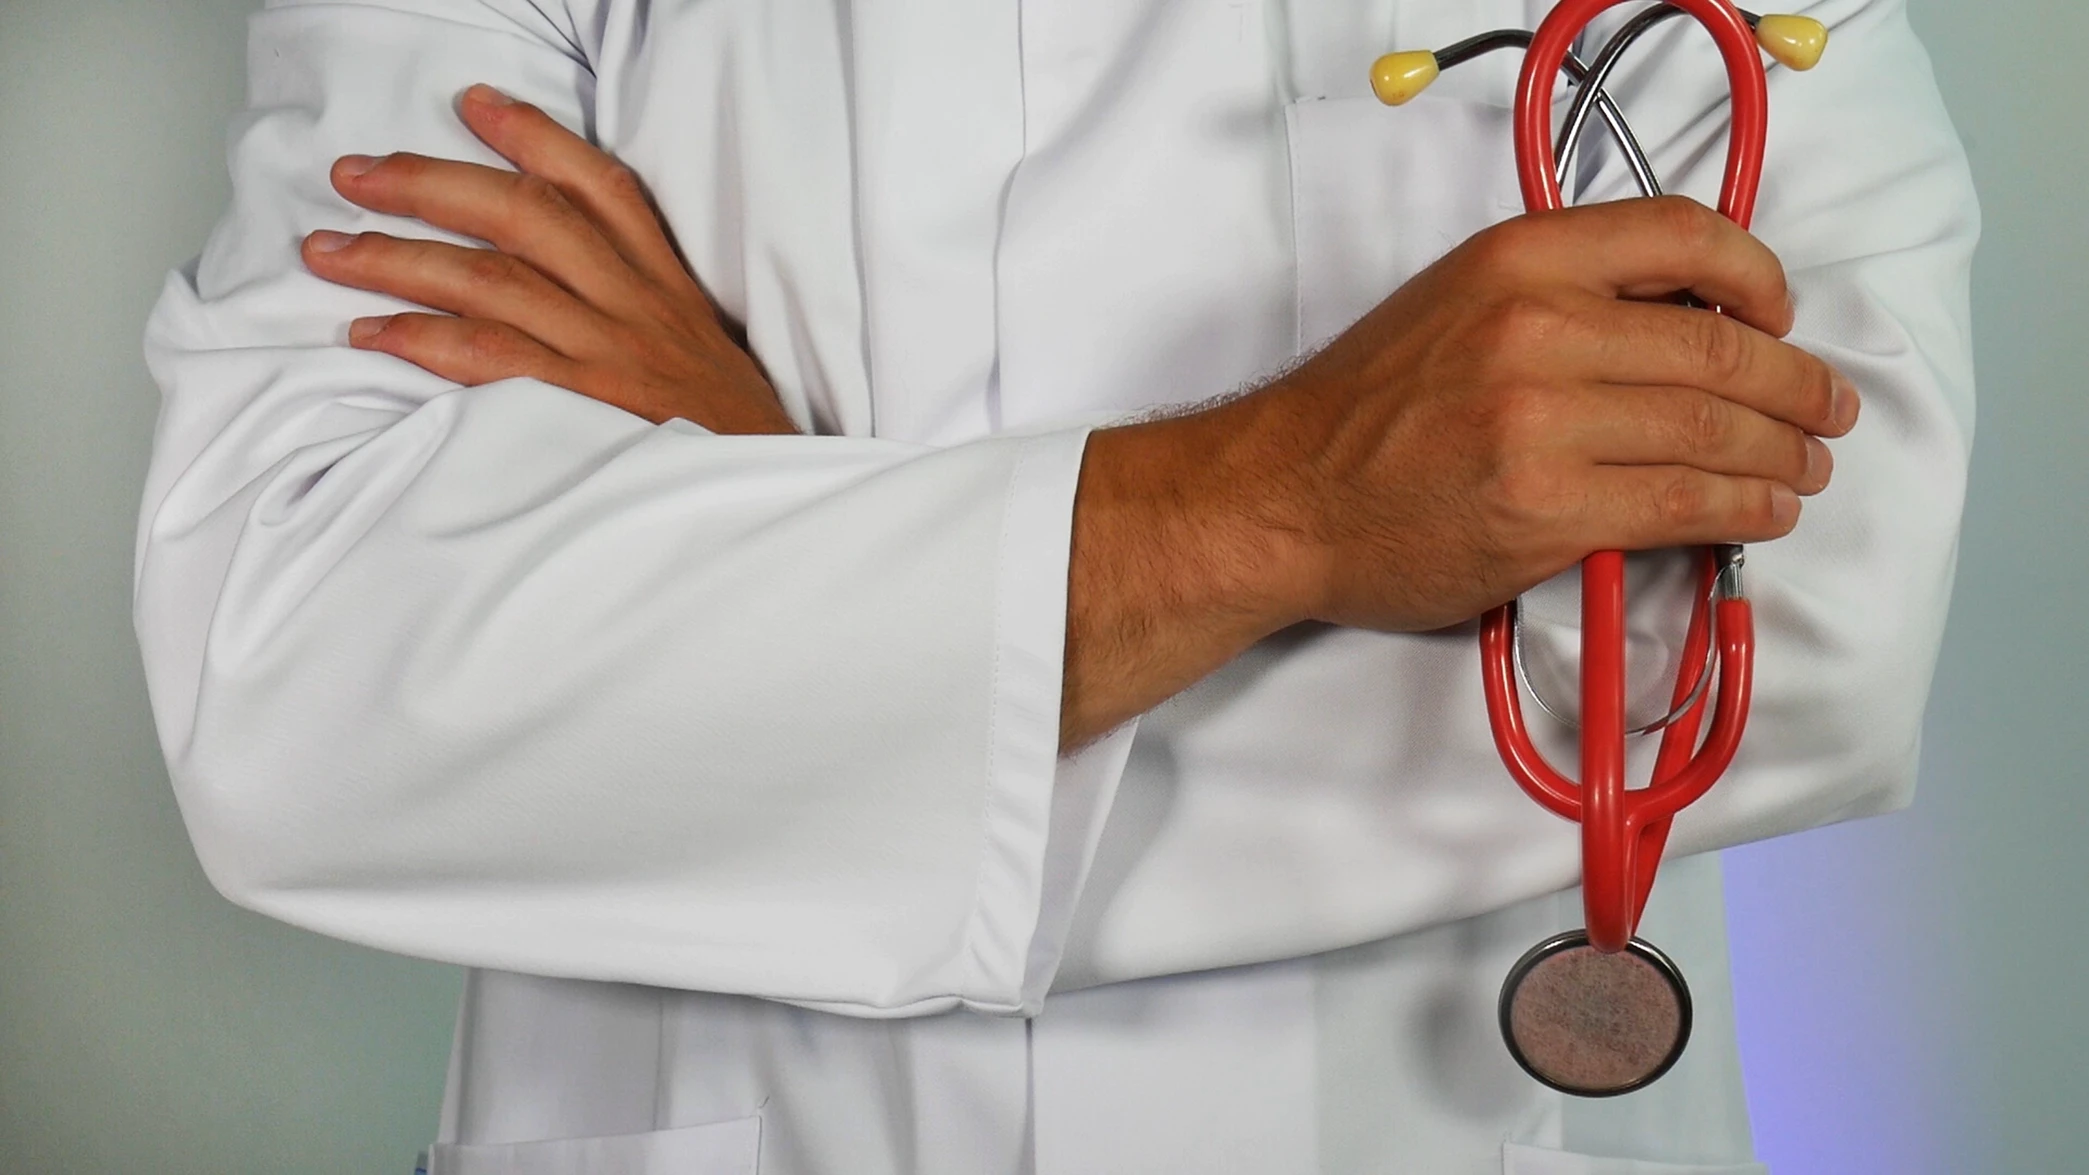

**Features of the Data**
LB - FHR baseline (beats per minute)
-AC - # of accelerations per second
-FM - # of fetal movements per second
UC - # of uterine contractions per second
DL - # of light decelerations per second
DS - # of severe decelerations per second
DP - # of prolongued decelerations per second
ASTV - percentage of time with abnormal short term variability
MSTV - mean value of short term variability
ALTV - percentage of time with abnormal long term variability
MLTV - mean value of long term variability
Width - width of FHR histogram
Min - minimum of FHR histogram
Max - Maximum of FHR histogram
Nmax - # of histogram peaks
Nzeros - # of histogram zeros
Mode - histogram mode
Mean - histogram mean
Median - histogram median
Variance - histogram variance
Tendency - histogram tendency
CLASS - FHR pattern class code (1 to 10)
NSP - fetal state class code (N=normal; S=suspect; P=pathologic)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [145]:
#To be able to correctly read the XLS you should copy the Data Tab into a new sheet, and remove the empty columns
#then read that sheet. 
df = pd.read_excel('CTG.xls', sheet_name = 'Data_new',  heading = True)

In [146]:
df.head()

,b,e,AC,FM,UC,DL,DS,DP,DR,LB,...,C,D,E,AD,DE,LD,FS,SUSP,CLASS,NSP
0,240,357,0,0,0,0,0,0,0,120,...,-1,-1,-1,-1,-1,-1,1,-1,9,2
1,5,632,4,0,4,2,0,0,0,132,...,-1,-1,-1,1,-1,-1,-1,-1,6,1
2,177,779,2,0,5,2,0,0,0,133,...,-1,-1,-1,1,-1,-1,-1,-1,6,1
3,411,1192,2,0,6,2,0,0,0,134,...,-1,-1,-1,1,-1,-1,-1,-1,6,1
4,533,1147,4,0,5,0,0,0,0,132,...,-1,-1,-1,-1,-1,-1,-1,-1,2,1


In [147]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 42 columns):
b           2126 non-null int64
e           2126 non-null int64
AC          2126 non-null int64
FM          2126 non-null int64
UC          2126 non-null int64
DL          2126 non-null int64
DS          2126 non-null int64
DP          2126 non-null int64
DR          2126 non-null int64
LB          2126 non-null int64
AC.1        2126 non-null float64
FM.1        2126 non-null float64
UC.1        2126 non-null float64
DL.1        2126 non-null float64
DS.1        2126 non-null float64
DP.1        2126 non-null float64
ASTV        2126 non-null int64
MSTV        2126 non-null float64
ALTV        2126 non-null int64
MLTV        2126 non-null float64
Width       2126 non-null int64
Min         2126 non-null int64
Max         2126 non-null int64
Nmax        2126 non-null int64
Nzeros      2126 non-null int64
Mode        2126 non-null int64
Mean        2126 non-null int64
Median      2

In [148]:
#This is our target, where the values represent the following: Normal=1; Suspect=2; Pathologic=3
df['NSP'].value_counts()

1    1655
2     295
3     176
Name: NSP, dtype: int64

In [149]:
#We change all of the 3 (Pathologics) to be the target 
df['target'] = df['NSP'].apply(lambda NSP: 1 if NSP != 1 else 0)
df = df.drop(['NSP','CLASS', 'SUSP'], axis = 1)

In [150]:
#Seeing the proportion of 1s in our data:
ratio_ones = df['target'].sum() / len(df)
print("The ratio of ones is: {}".format(ratio_ones))

The ratio of ones is: 0.2215428033866416


In [151]:
#Train - test split
from sklearn.model_selection import train_test_split

In [152]:
Y = df['target']
X = df.drop(['target'], axis = 1)

In [153]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [154]:
#Lets use a Logistic Regression model to make predictions for our data
from sklearn.linear_model import LogisticRegression

In [155]:
clf = LogisticRegression(random_state=42).fit(X_train, y_train)

C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [156]:
preds = clf.predict(X_test)

In [176]:
def plot_Lift_curve(y_val, y_pred, step=0.01):
    
    #Define an auxiliar dataframe to plot the curve
    aux_lift = pd.DataFrame()
    #Create a real and predicted column for our new DataFrame and assign values
    aux_lift['real'] = y_val
    aux_lift['predicted'] = y_pred
    #Order the values for the predicted probability column:
    aux_lift.sort_values('predicted',ascending=False,inplace=True)
    
    #Create the values that will go into the X axis of our plot
    x_val = np.arange(step,1+step,step)
    #Calculate the ratio of ones in our data
    ratio_ones = aux_lift['real'].sum() / len(aux_lift)
    #Create an empty vector with the values that will go on the Y axis our our plot
    y_v = []
    
    #Calculate for each x value its correspondent y value
    for x in x_val:
        num_data = int(np.ceil(x*len(aux_lift))) #The ceil function returns the closest integer bigger than our number 
        data_here = aux_lift.iloc[:num_data,:]   # ie. np.ceil(1.4) = 2
        ratio_ones_here = data_here['real'].sum()/len(data_here)
        y_v.append(ratio_ones_here / ratio_ones)
           
   #Plot the figure
    fig, axis = plt.subplots()
    fig.figsize = (40,40)
    axis.plot(x_val, y_v, 'g-', linewidth = 3, markersize = 5)
    axis.plot(x_val, np.ones(len(x_val)), 'k-')
    axis.set_xlabel('Proportion of sample')
    axis.set_ylabel('Lift')
    plt.title('Lift Curve')
    plt.show()

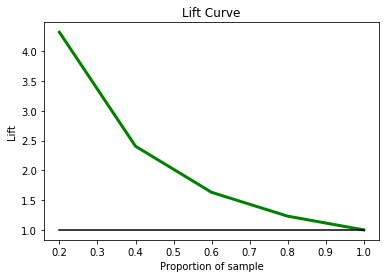

In [177]:
plot_Lift_curve(y_test,preds, 0.2)
#Change step later to 0.01

In [159]:
from sklearn.metrics import confusion_matrix

In [160]:
confusion_matrix(y_test, preds)

array([[488,   8],
       [  5, 137]], dtype=int64)